# Will you visit my restaurant ? - An Hybrid Recommendation System  

**Author** : Charles Gaydon

**Date** : 25/01/2018

**Context** : This work was done as part of a Machine Learning course taught at the University of Lyon, as part of the **Data Science Master's Degree**.

**Objectives** : 

We have three files, containing informations about :
- Restaurants : 461 restaurants and anonymous labels describing them, 
- Clients : 192 clients of those restaurants, i.e. that have visited at least one of them in the past, described by 9 anonymous quantitatives variables;
- Visits : a 192x461 matrix indicating whether the ith customer has visited (v(i,j) = 1) or not (v(i,j) = 0) the jth restaurant. 

We will hereby do two things :
- propose a general method to recommend or not a new restaurant to a new customer, 
- and then develop and validate an **Ensemble Chained Classifier** to recommend the top-k restaurants that could best please a new customer.

## 1. Setting

In [1]:
# quelques imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# various models for possible exploration
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold,GridSearchCV,cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# Models for the Classifier Chain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_similarity_score

# models for the Ensemble Classifier Chain
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_curve, auc

In [2]:
user_path = "data/clients.data.csv"
rest_path = "data/restaurants.data.csv"
visits_path = "data/visites.data.csv"

U = pd.read_csv(user_path, header=None, sep = ',', names = ["Uid"]+["u"+str(x) for x in range(9)])
U = U.set_index(["Uid"])
R = pd.read_csv(rest_path, sep = ',')
R = R.set_index(["restau_id"])
V = pd.read_csv(visits_path, sep = ';')
V = V.set_index(["uuid"])
U.shape, V.shape, R.shape

((192, 9), (192, 422), (422, 31))

We extract the user and restaurant for which we will want to make a recommendation. We also remove the visits data linked to them.

In [3]:
Un = U.tail(1)
U = U[:-1]

Vn = V.tail(1)
V = V[:-1]
Vp = V.iloc[:,-1]
V = V.iloc[:,:-1]

Rn = R.tail(1)
R = R[:-1]

U.shape, V.shape, R.shape

((191, 9), (191, 421), (421, 31))

We see that some restaurants have never been visited, hich will cause some warnings in the later models.

In [4]:
Vd = V.describe()
np.sum(Vd.reset_index().iloc[1].values==0) # check if visit mean==0

132

## 2. Predictions for a new user and a new restaurant all at once

We hereby show the general methode that we follow to predict for unseen user AND restaurant.

We don't optmize yet our models individually, and make the choice of simplicity by using a OneVsRestClassifier, which considers the labels independantly. *Note that this model is equivalent to MultiOutputClassifier, as this is a multilabel problem and not a multiclass problem.*

**Few model for exploration**

In [5]:
models = {"KNN" : KNeighborsClassifier(n_neighbors=6),
          "DT" : DecisionTreeClassifier(),
         "RF": RandomForestClassifier(n_estimators=20,n_jobs=-1),
         "ADA" : AdaBoostClassifier(n_estimators =30),
         "MLP" : MLPClassifier(hidden_layer_sizes = (80,40)),
         "BAG" : BaggingClassifier(n_estimators =95,n_jobs=-1),
         "NB" : GaussianNB()}
m = models["DT"]

mU = OneVsRestClassifier(LogisticRegression(),n_jobs=-1)
mR = OneVsRestClassifier(LogisticRegression(),n_jobs=-1)

**Method**
- Step 1. we learn to predict the visits V from the user matrix U;
- Step 2. we make a prediction for the unknown user Vn and add it to the matrix V;
- Step 3. we learn to predict the (transposed) visits matrix Vt from the restaurants matrix R;
- Step 4. we use the last model to predict the interest of the unknown user Vn for the unknown restaurant Rn. 

In [6]:
def recommend_New_for_New(mU, mR, U=U, V=V, R=R, Un=Un, Rn=Rn):

    #fit the mU models and predict the tastes of the new user
    mU.fit(U.values, V.values)
    Vn_hat =  mU.predict(Un)

    # add user-based prediction to visits and retrain mR
    mR.fit(R.values, np.transpose(np.concatenate([V.values, Vn_hat],axis=0)))

    # predict again the visit, ut for the new restaurant now
    Vt_hat = mR.predict(Rn)
    Vt_new = Vt_hat[0][-1] #last element is for the new restaurant
    return(Vt_new)
print("Recommend the restaurant to the new user : " + str(bool(recommend_New_for_New(mU, mR))))
print("Did he actually visit the restaurant ?  " + str(bool(Vn.values[0][-1])))

/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/m

/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 135 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 69 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 102 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 118 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/

/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 274 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 306 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 262 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 276 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 308 is present in all training examples.
  str(classes[c]))
/home/cgaydon/Ressources/anaconda3/envs/DS_bash/lib/python3.5/site-packages

Recommend the restaurant to the new user : False
Did he actually visit the restaurant ?  False


## 3. Predictions for a new user with an ensemble classifier chain
We base our script on [this sklearn snippet](http://scikit-learn.org/stable/auto_examples/multioutput/plot_classifier_chain_yeast.html), but use 5-fold cross-validation with shuffling to evaluate the jaccard index, and the ROC. The latter is more informative, as it takes into account the fact that non-visited restaurants is not a criteria of absence of interest from a user. 

Cross-val #1
fitted
predicted


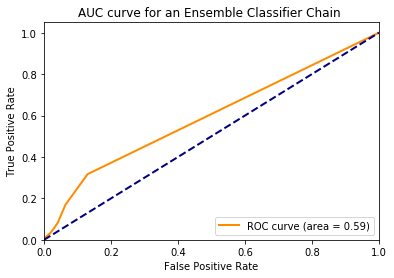

Ensemble jaccard score : 0.00620422346966
Cross-val #2
fitted
predicted


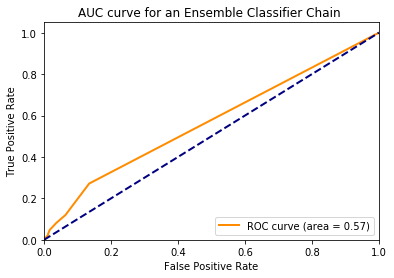

Ensemble jaccard score : 0.00923645320197
Cross-val #3
fitted
predicted


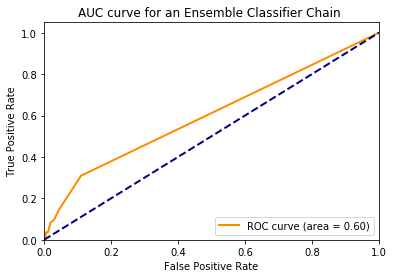

Ensemble jaccard score : 0.00801114594218
Cross-val #4
fitted
predicted


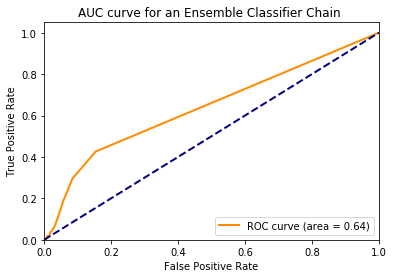

Ensemble jaccard score : 0.00418756139172
Cross-val #5
fitted
predicted


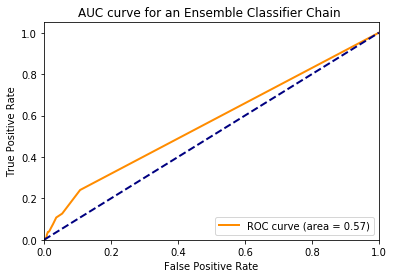

Ensemble jaccard score : 0.00790046153394


In [121]:
n_chains = 20
threshold = 0.5
models = {"DT" : DecisionTreeClassifier(random_state =1),
          "MLP" : MLPClassifier(hidden_layer_sizes = (5,5,5)),
         }
m = models["DT"]

chains = [ClassifierChain(m, order='random', random_state=i, cv = None)
          for i in range(20)]
ss = ShuffleSplit(n_splits=5, test_size=0.15,random_state=0)
score = jaccard_similarity_score
i=1
for train, test in ss.split(U.values):
    print("Cross-val #"+str(i))
    i+=1
    X_train = U.values[train]
    X_test = U.values[test]
    Y_train = V.values[train]
    Y_test = V.values[test]
    
    [chain.fit(X_train, Y_train) for chain in chains]
    print("fitted")
    Y_pred_chains = np.array([chain.predict(X_test) for chain in chains]) #can't use predict_proba ?
    chain_scores = [score(Y_test, Y_pred_chain >= threshold)
                            for Y_pred_chain in Y_pred_chains]
    
    Y_pred_ensemble = Y_pred_chains.mean(axis=0)
    print("predicted")
    ensemble_score = score(Y_test,Y_pred_ensemble >= threshold)
    
    #plot ROC
    plt.figure()
    lw = 2
    fpr, tpr, dth = roc_curve(Y_test.ravel(),Y_pred_ensemble.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC curve for an Ensemble Classifier Chain ')
    plt.legend(loc="lower right")
    plt.show()

    print("Ensemble jaccard score : " + str(ensemble_score))


We set the decision threshold at 0.15 to aximise the True Positive Rate at ~35%, which is maybe not enough to actually make a decision for a single new restaurant, but should be enough to give some recommendations to a new user. 

In [97]:
threshold = 0.15
def recommend_for_new_U(chains, my_Un, k=5):
    Y_pred_chains = np.array([chain.predict(my_Un) for chain in chains])
    Y_pred_ensemble = Y_pred_chains.mean(axis=0)[0]
    
    probs = sorted(Y_pred_ensemble,reverse=True)[:k]
    idx =  sorted(range(len(Y_pred_ensemble)),key = lambda x : Y_pred_ensemble[x],reverse=True)[:k]
    return (idx, np.array(probs)>= threshold)
idx, reco = recommend_for_new_U(chains, Un.values, k=10)
print(R.index[idx].values,'\n \n', reco)

['restau_444' 'restau_150' 'restau_23' 'restau_22' 'restau_144'
 'restau_194' 'restau_263' 'restau_20' 'restau_362' 'restau_382'] 
 
 [ True  True  True  True  True  True  True  True  True  True]


In [122]:
print("Has the user actually visited the restuarants ? no : ", *Vn[Vn.columns[idx]].values[0])
print("but the user only visited a few restaurants, " , np.sum(Vn.values) ,
      "to be precise, over the", Vn.values.shape[1], "restaurants, so this does not invalidate the recommendation :).")

Has the user actually visited the restuarants ? no :  0 0 0 0 0 0 0 0 0 0
but the user only visited a few restaurants,  7 to be precise, over the 422 restaurants, so this does not invalidate the recommendation :).


### 2.3 And after ?

In section 2.2, we developped a first recommendation system that can advice a new customer on the restaurant that would best suit him or her. With a 5-fold cross-validation, we determined the threshold for an actual recommandation, and measured that our model has a quite acceptable True Positive Rate of around **35%**. Taking into account the fact that False Positive does not necessary mean that the prediction was false, but only that the restaurant was (just maybe) not yet visited by the user. 

**As a result, the output probabilities enables one to select the top-k restaurants of interest with rather good confidence that the user will be satisfied :) **.

The concept of an Ensemble Chained Classifier could be replicated for a prediction *restaurant -> visit*. The two models could then be included in the model from 2.1 where a new restaurant has to be recommended to a new client about which we don't know the interest. 
![title](pizza.png)